# 衰减率：
### 安装阻尼器后轨道横向和垂向振动衰减率在4000Hz以上频段均不小于5dB/m，
### 160-4000Hz频段轨道横向与垂向平均振动衰减率不小于5.5dB/m

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sg
import xlrd

In [2]:
#1/3倍频程中心频率
freqs_3 = np.array([1.00e+00, 1.25e+00, 1.60e+00, 2.00e+00, 2.50e+00, 3.15e+00,
                    4.00e+00, 5.00e+00, 6.30e+00, 8.00e+00, 1.00e+01, 1.25e+01, 
                    1.60e+01, 2.00e+01, 2.50e+01, 3.15e+01, 4.00e+01, 5.00e+01,
                    6.30e+01, 8.00e+01, 1.00e+02, 1.25e+02, 1.60e+02, 2.00e+02,
                    2.50e+02, 3.15e+02, 4.00e+02, 5.00e+02, 6.30e+02, 8.00e+02, 
                    1.00e+03, 1.25e+03, 1.60e+03, 2.00e+03, 2.50e+03, 3.15e+03,
                    4.00e+03, 5.00e+03, 6.30e+03, 8.00e+03, 1.00e+04, 1.25e+04, 
                    1.60e+04,2.00e+04])
#v0
v0 = 1.00e-6
#1-80HZ 计权
print(freqs_3 [:27])
#160-4kHZ计权
print(freqs_3 [22:37])
#50-5000Hz
print(freqs_3 [17:39])

[  1.     1.25   1.6    2.     2.5    3.15   4.     5.     6.3    8.
  10.    12.5   16.    20.    25.    31.5   40.    50.    63.    80.
 100.   125.   160.   200.   250.   315.   400.  ]
[ 160.  200.  250.  315.  400.  500.  630.  800. 1000. 1250. 1600. 2000.
 2500. 3150. 4000.]
[  50.   63.   80.  100.  125.  160.  200.  250.  315.  400.  500.  630.
  800. 1000. 1250. 1600. 2000. 2500. 3150. 4000. 5000. 6300.]


In [3]:
def nextpow2(max_ele):
    n = 0
    while 2**n < max_ele:
        n += 1
    return 2**n

In [4]:
def calculate(address, measure_frqs, freqs_order,channal):
    
    #读取数据
    workbook = xlrd.open_workbook(address)
    Data_sheet = workbook.sheets()[0] 
    #声压时程
    t = Data_sheet.col_values(0)
    p_t  = Data_sheet.col_values(channal)
    data_len = len(p_t)
    #plt.figure(figsize=(14,8), dpi=200)
    #plt.plot(t,p_t)
    
    #加汉宁窗(恢复系数为1.633)
    #p_t = 1.633 * np.hamming(data_len) * p_t
    #p_t = 1.633 * np.hanning(data_len) * p_t
    nfft = nextpow2(data_len)
    p_f = np.fft.fft(p_t,nfft)
    fx =  measure_frqs/2 * np.linspace(0,1,nfft/2)
    w = 2 * np.abs(p_f[:int(nfft/2)]/data_len)
    #w = np.abs(np.abs(p_f[:int(nfft/2)]/data_len))
    #绘制频谱
    #plt.figure(figsize=(14,8), dpi=200)
    #plt.semilogx(fx,w)
    
     # 求取1/3频程起止频率
    f_start =  freqs_order * 2 ** (-1 / 6)  
    f_stop = freqs_order * 2 ** (1 / 6)  
    
    #print(f_start)
    #分频带滤波   
    
    m = len(freqs_order)
    y_out = np.zeros(m)
    #'''
    #print(index_start,index_end)
    for i in range(m):
        index_start = int(np.round(f_start[i]*nfft/measure_frqs))
        index_end = int(np.round(f_stop[i]*nfft/measure_frqs))
        #index_end = int(np.round(f_start[i+1]*nfft/measure_frqs))
        data = np.zeros(nfft,dtype=np.complex)
        data[index_start:index_end] = p_f[index_start:index_end]
        data[nfft-1-index_end:nfft-1-index_start] = p_f[nfft-1-index_end:nfft-1-index_start]
        if f_stop[i]>measure_frqs/2:
            y_out[i] = v0
        else:
            data_ifft = np.fft.ifft(data,nfft)
            y_out[i] = np.power(np.var(data_ifft[:data_len].real),0.5)
    
    #print(y_out)

    #y_out_1 = 10*np.log10(y_out**2 * 9.8**2/v0**2)
    y_out_1 = y_out*9.8

    #y_out_Z = 10*np.log10(np.power(10,(y_out_1+Weighting_factor)/10))
    non_out = 10*np.log10(sum(np.power(10,y_out_1/10)))
    #A_out = 10*np.log10(sum(np.power(10,(y_out_1+Weighting_factor)/10)))

    #return y_out_1,y_out_Z,non_out,A_out 
    #return y_out_1,non_out
    return y_out_1

/Users/guowuji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


number of chanal:  2


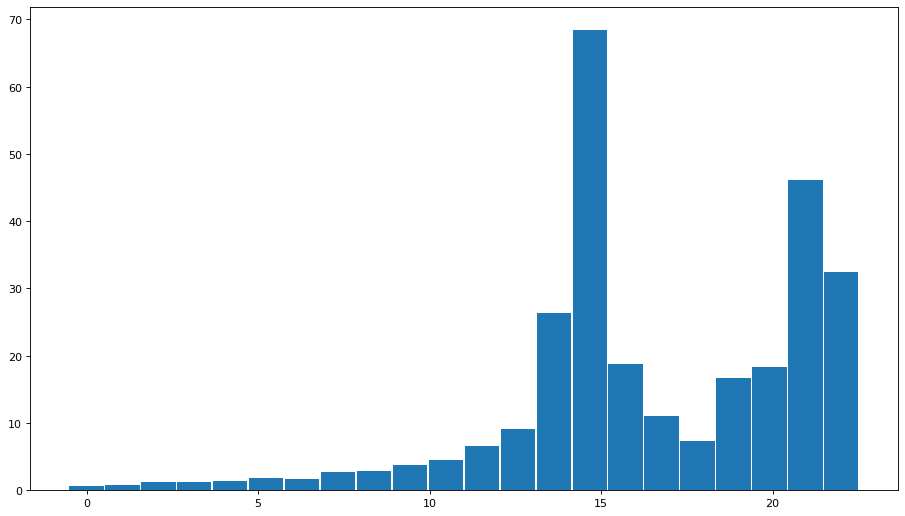

number of chanal:  3


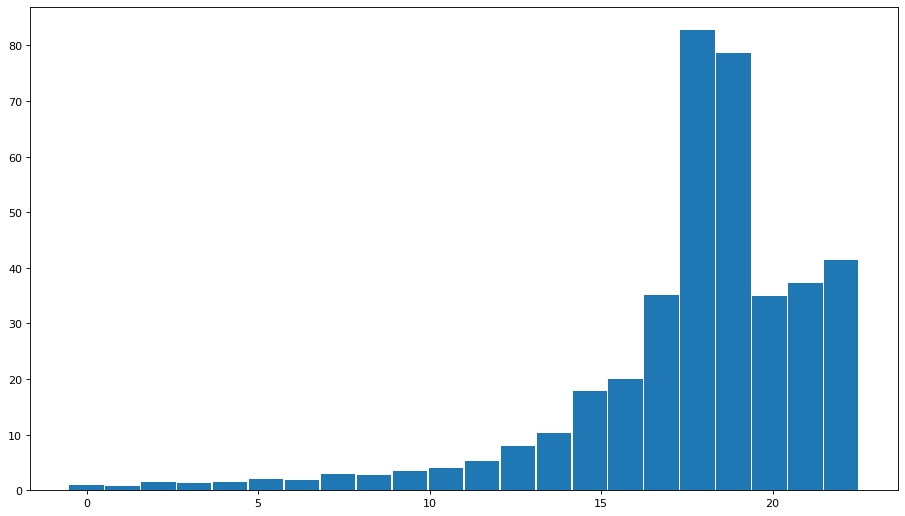

number of chanal:  4


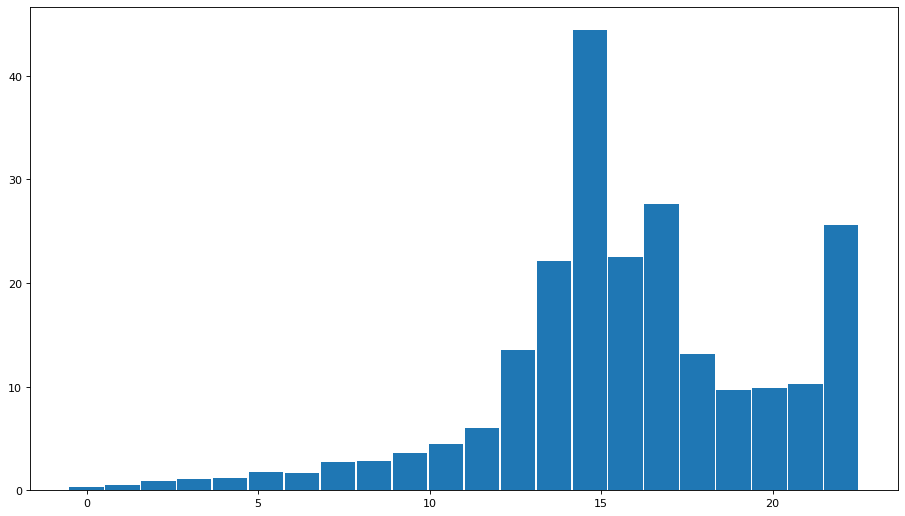

number of chanal:  5


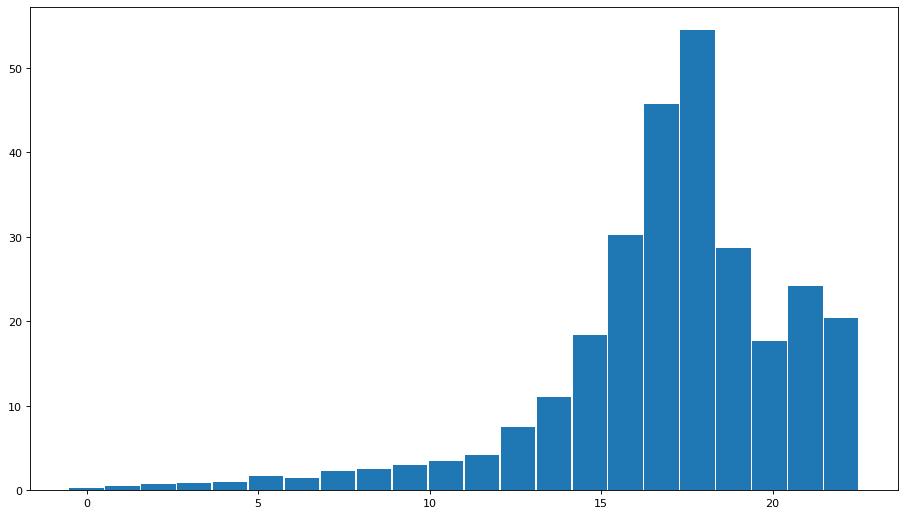

number of chanal:  6


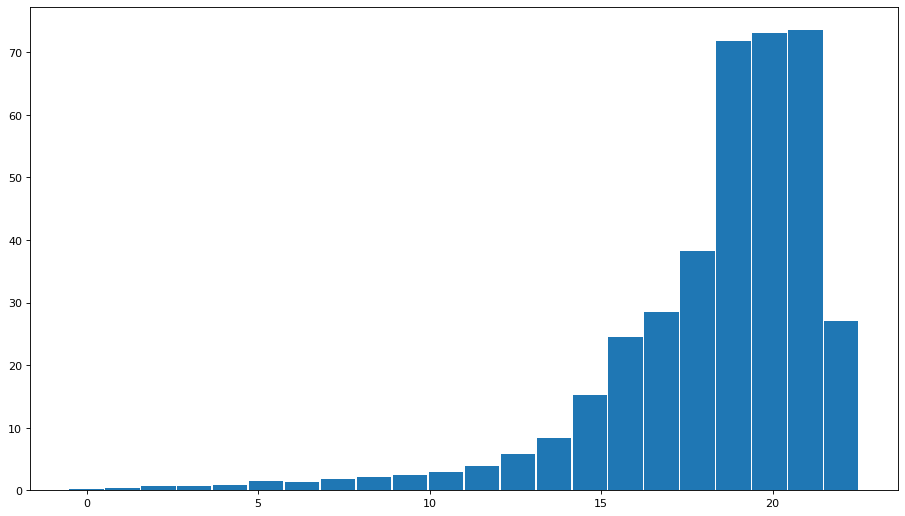

number of chanal:  7


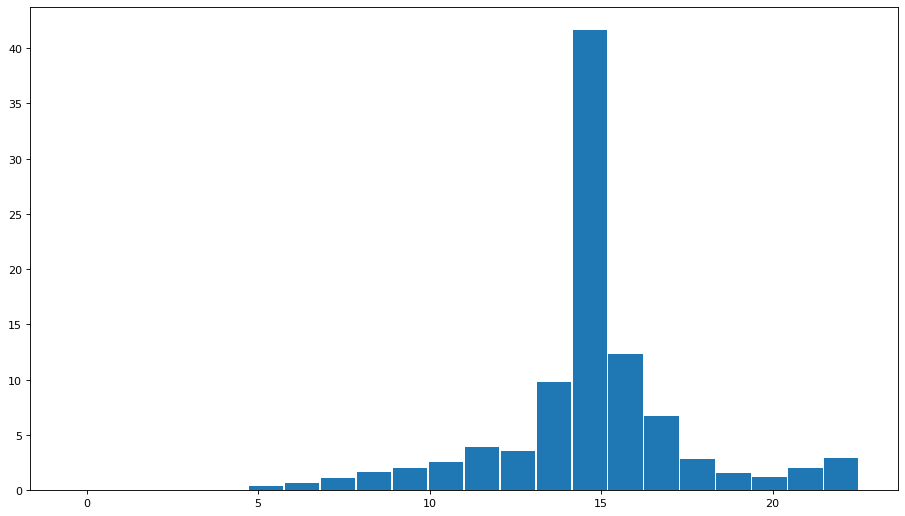

number of chanal:  8


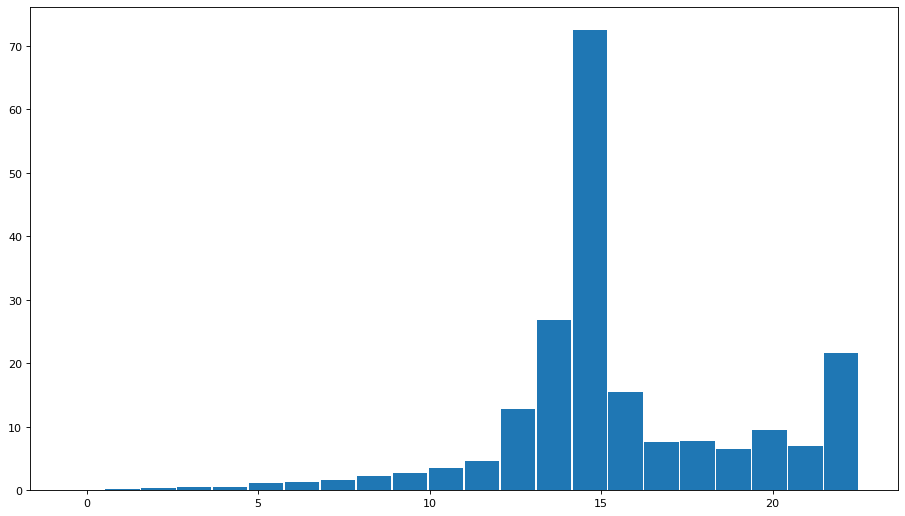

number of chanal:  9


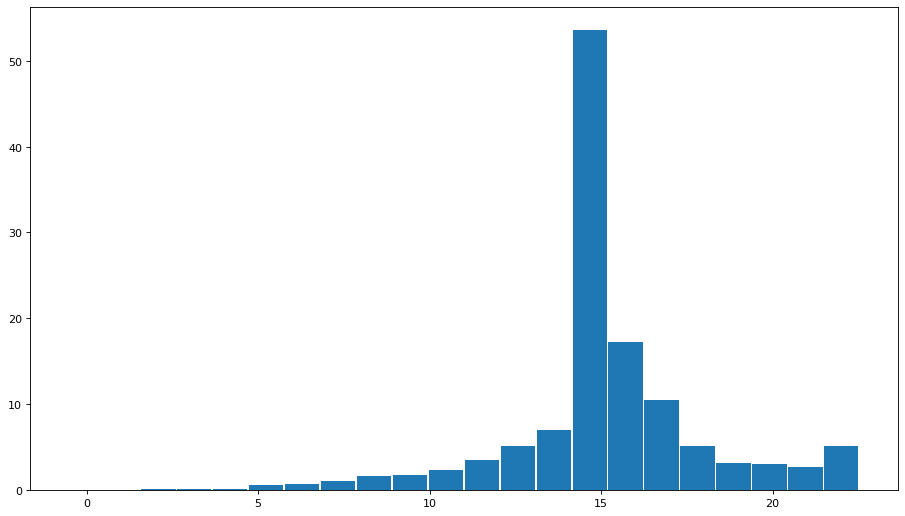

number of chanal:  10


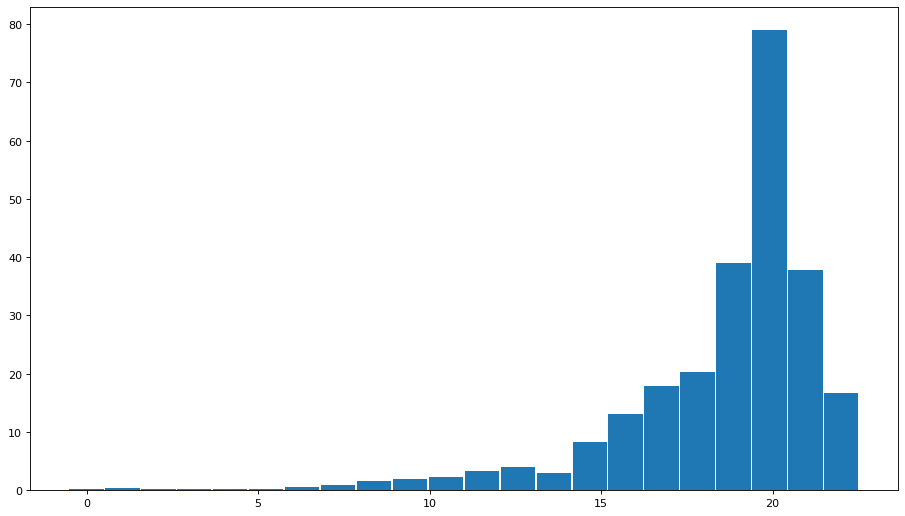

In [19]:
if __name__ == '__main__':
    
    #读入文件地址
    ads = '/Users/guowuji/Documents/measure_data/dr/z_2_3.xlsx'
    #采集频率
    measure_frqs = 20000
    out_non = np.zeros((10,22))
    non = np.zeros(22)
    for i in range(2,11):
        #out_non,out_Z, non, Z = calculate(ads, measure_frqs, freqs_3[22:37], Wght_fct[:20],i)
        #out_non[i-2], non[i-2] = calculate(ads, measure_frqs, freqs_3[17:39], i)
        out_non[i-2] = calculate(ads, measure_frqs, freqs_3[17:39], i)
        print("number of chanal: " , i)
        #print("non=",non)
        #print(out_non)
        #print("Z=",Z)
        #print(out_Z)
        plt.figure(figsize=(14,8), dpi=80)
        plt.bar(np.linspace(0,22,22),out_non[i-2],1,align='center')
        plt.show()

[5.89768781 6.5429235  6.3504866  6.24505611 5.14571561 3.36380171
 2.77342151 3.03457046 1.97465135 2.42200056 2.21083792 2.37373543
 1.65936304 4.08420386 2.26814582 1.05349869 0.30729464 0.08217026
 0.29304664 0.19143458 2.62003588 3.45289092]


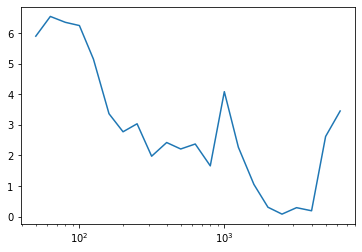

In [20]:
#自测
dx = np.array([0,1/4,1/4,1/2,1/2,1/2,1,1,2,2,2])
dx_1 = (dx[:-1]+dx[1:])/2
#print(dx_1)
dx_2 = np.array([0.125,0.25,0.375,0.5,0.5,2,0.75,2,1.5,1])*0.6
out_non1 = out_non**2 * dx_2.reshape(10,1)
DR = 4.343 * out_non[0]**2 / np.sum(out_non1,0)
plt.semilogx(freqs_3[17:39],DR)
print(DR)

freqs is  50.0


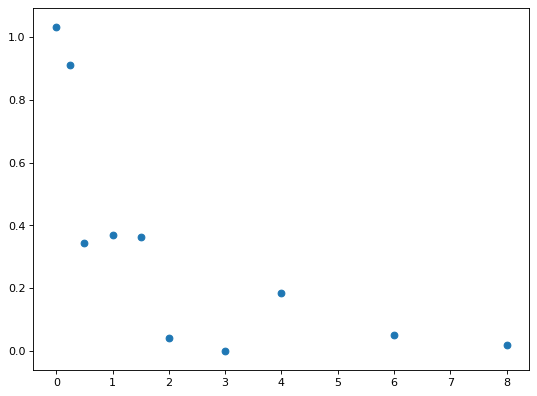

freqs is  63.0


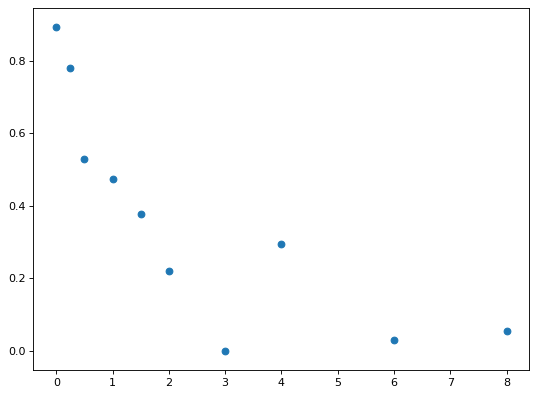

freqs is  80.0


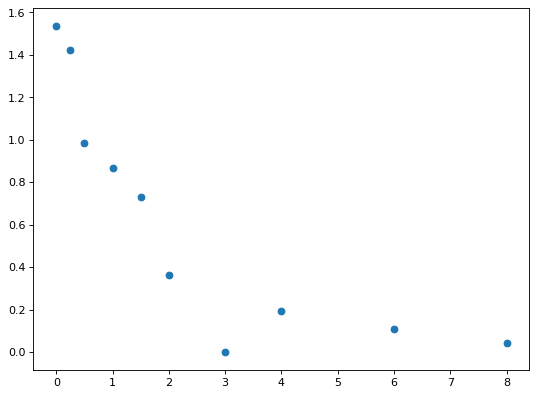

freqs is  100.0


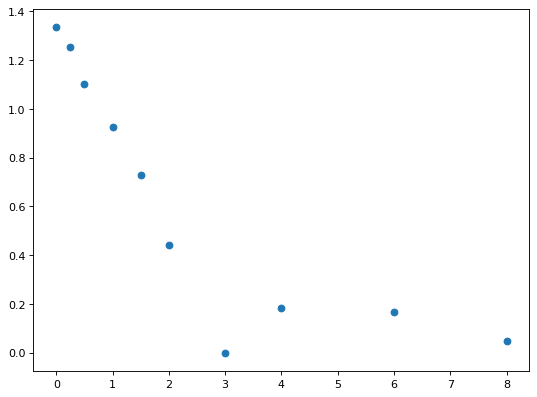

freqs is  125.0


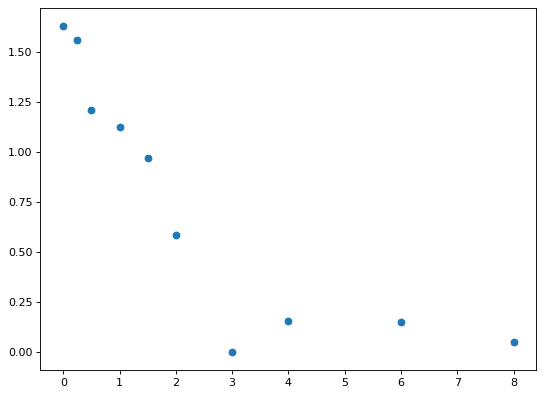

freqs is  160.0


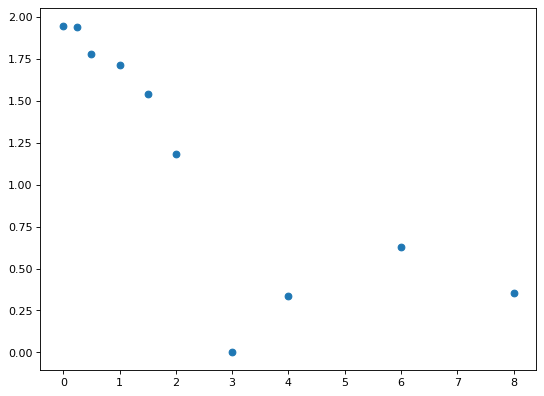

freqs is  200.0


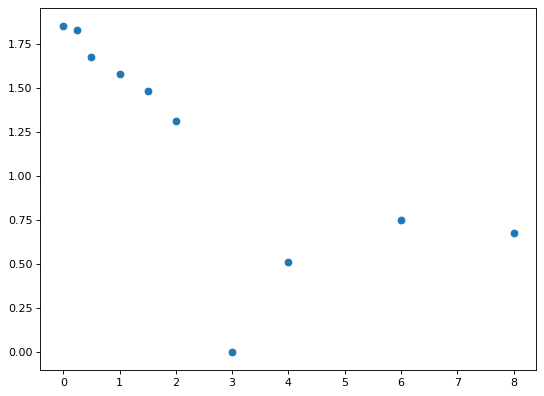

freqs is  250.0


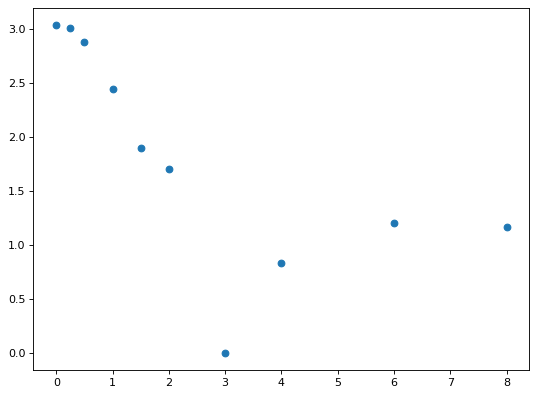

freqs is  315.0


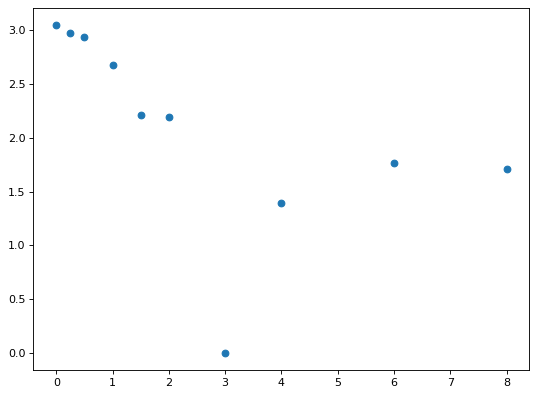

freqs is  400.0


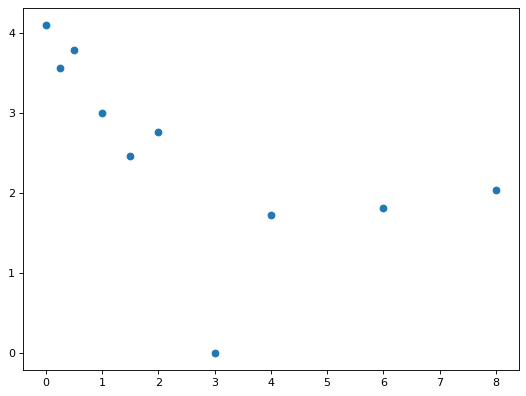

freqs is  500.0


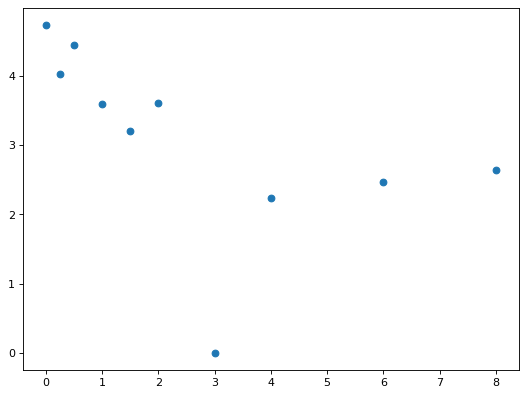

freqs is  630.0


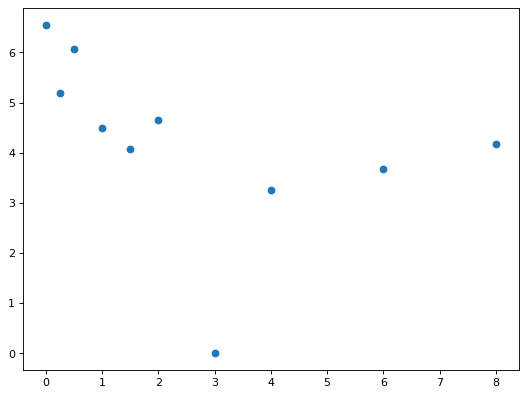

freqs is  800.0


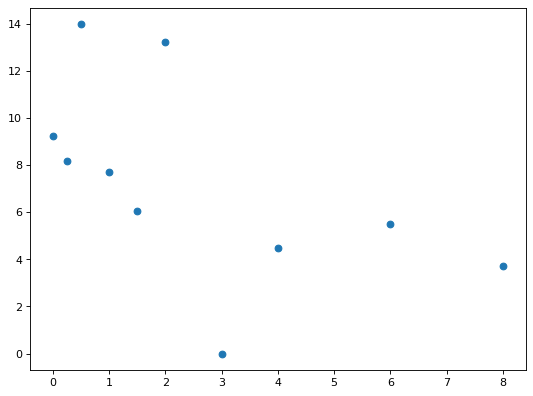

freqs is  1000.0


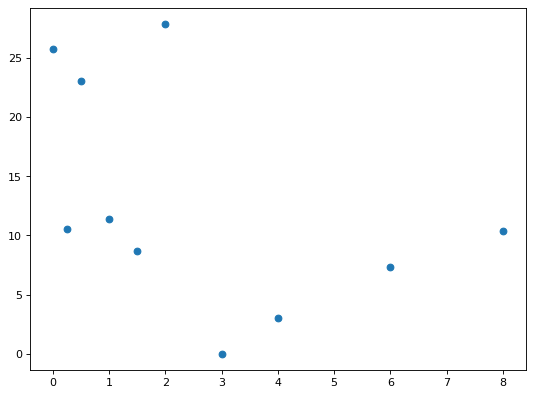

freqs is  1250.0


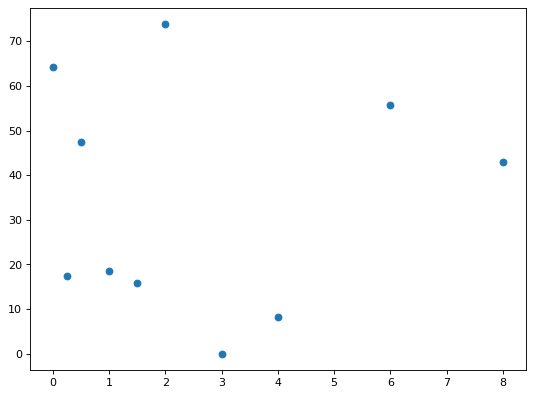

freqs is  1600.0


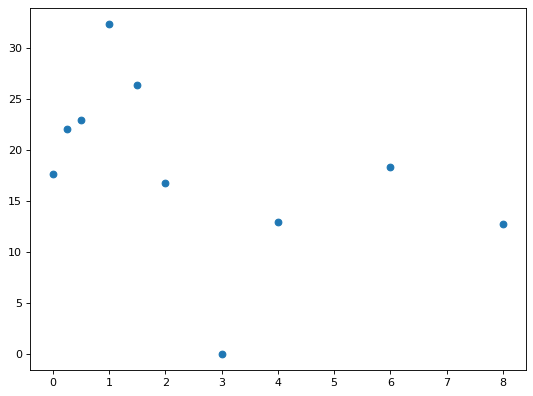

freqs is  2000.0


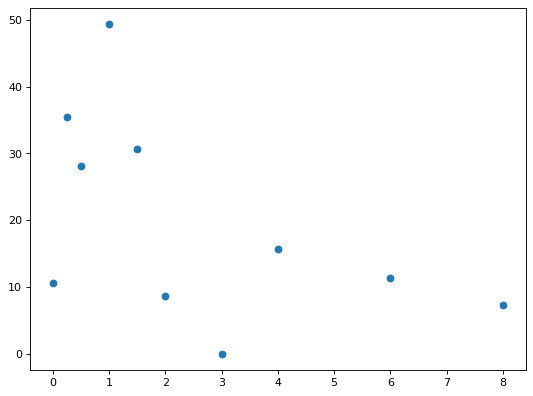

freqs is  2500.0


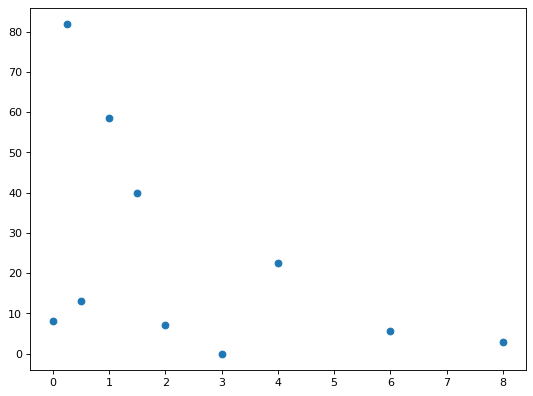

freqs is  3150.0


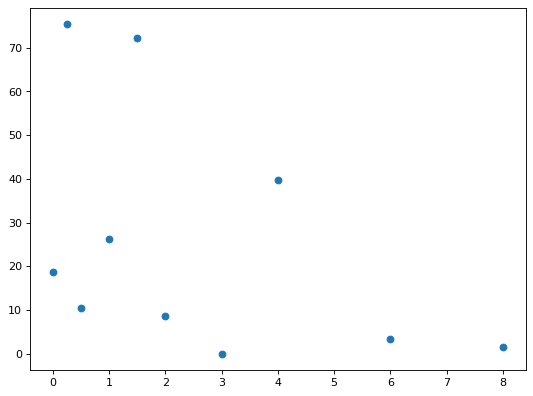

freqs is  4000.0


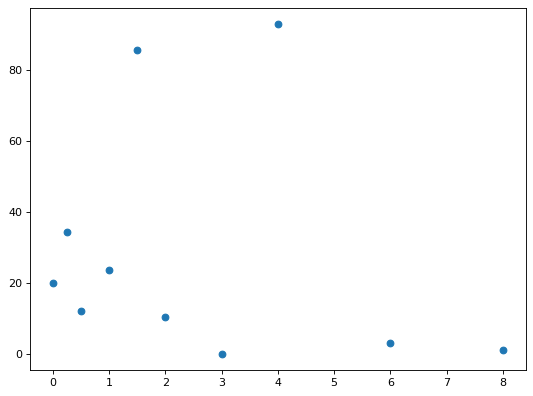

freqs is  5000.0


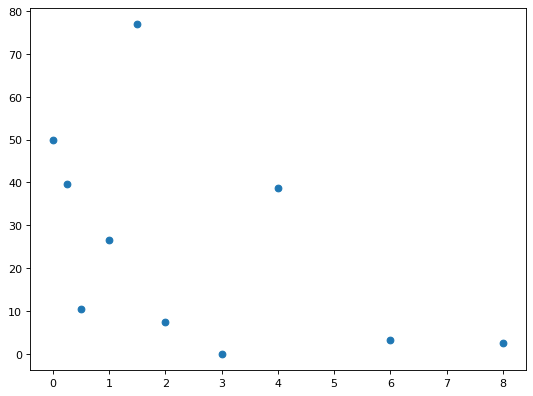

freqs is  6300.0


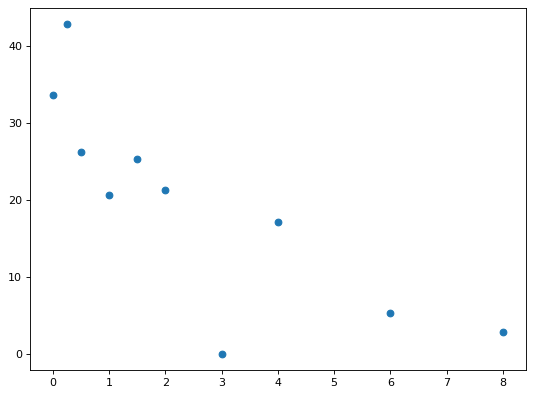

In [18]:
fre = out_non.T
dx_3 = np.array([0,1/4,1/2,1,3/2,2,3,4,6,8])#1 2 3 4 5 10 6 9 8 7
dx_4 = np.array([0,1/4,1/2,1,3/2,8,2,6,4,3])
for i in range(22):
    print("freqs is ",freqs_3 [17+i])
    plt.figure(figsize=(8,6), dpi=80)
    ax = plt.subplot(111)
    ax.scatter(dx_4,fre[i])
    plt.show()

In [8]:
sum(dx)

10.0

In [37]:
u = np.array([[1,2,3,4], 
             [4,5,6,5], 
             [7,8,9,6]])

In [38]:
u.T

array([[1, 4, 7],
       [2, 5, 8],
       [3, 6, 9],
       [4, 5, 6]])

In [40]:
u.reshape(1,12)

array([[1, 2, 3, 4, 4, 5, 6, 5, 7, 8, 9, 6]])

In [38]:
(u**2)*([1],[2],[3])

array([[  1,   4,   9,  16],
       [ 32,  50,  72,  50],
       [147, 192, 243, 108]])

In [26]:
4.343/5.4

0.8042592592592592